## ANALYZING THE EFFECT OF TEXT FEATURES ON DETERMINING THE PERIOD TO WHICH THE BOOK BELONGS - PERIOD_GENRE_CLASSIFICATION <br>
### THE QUESTION IS : To the readers in search of books in the range of particular time period, could the text description available be useful or not?

In [1]:
!pip install nltk
!pip install gensim

In [4]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim.downloader
#glove_vectors = gensim.downloader.load('glove-twitter-25')
from gensim.models import Phrases
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
#import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
#from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_auc_score,confusion_matrix, accuracy_score,recall_score,precision_score,f1_score,classification_report
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import re
import string
import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [151]:
from sklearn.preprocessing import StandardScaler

In [158]:
from sklearn import svm

In [8]:
import os
file_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.startswith('book'):
            file_list.append(os.path.join(dirname, filename))

df = pd.read_csv(file_list[0])
# rename columns to sentence case
df.rename(columns={c:c.title() for c in df.columns}, inplace=True)
for filename in file_list[1:]:
    df_tmp = pd.read_csv(filename)
    df_tmp.rename(columns={c:c.title() for c in df_tmp.columns}, inplace=True)
    df = pd.concat([df, df_tmp])
    print(df.shape)
# drop duplicated records
df.drop_duplicates(inplace=True)
print(df.shape)
df.head().T

(90025, 20)
(346620, 20)
(402802, 20)
(446363, 20)
(496206, 20)
(535069, 20)
(575959, 20)
(630232, 20)
(685388, 20)
(740247, 20)
(772352, 20)
(812057, 20)
(869103, 20)
(1265060, 20)
(1306952, 20)
(1362107, 20)
(1400395, 20)
(1433381, 20)
(1491673, 20)
(1526432, 20)
(1806688, 20)
(1850310, 20)
(1850198, 20)


,0,1,2,3,4
Ratingdist4,4:10,4:1,4:23,4:5969,4:15
Ratingdist1,1:2,1:0,1:0,1:278,1:2
Isbn,080959577X,1402158718,1598180339,0613607406,0859537803
Authors,Mrs. Henry Wood,Mrs. Henry Wood,Mrs. Henry Wood,Celia Rees,Arden Druce
Id,300002,300005,300007,300008,300009
Pagesnumber,487,310,380,261,32
Language,eng,NaN,NaN,NaN,NaN
Ratingdist3,3:5,3:1,3:11,3:4461,3:14
Name,The Channings,"William Allair; Or, Running Away To Sea",Anne Hereford,Witch Child,"Witch, Witch Come To My Party"
Publishyear,2004,2005,2006,2002,1991


In [15]:
df_2.describe().columns

Index(['Id', 'Pagesnumber', 'Publishyear', 'Countsofreview', 'Publishmonth',
       'Publishday', 'Rating', 'Count Of Text Reviews'],
      dtype='object')

In [16]:
df_2.columns

Index(['Ratingdist4', 'Ratingdist1', 'Isbn', 'Authors', 'Id', 'Pagesnumber',
       'Language', 'Ratingdist3', 'Name', 'Publishyear', 'Countsofreview',
       'Ratingdist5', 'Publishmonth', 'Ratingdist2', 'Publishday',
       'Ratingdisttotal', 'Rating', 'Publisher', 'Description',
       'Count Of Text Reviews'],
      dtype='object')

considering that dataset is updated every 2 days, only till the year 2022 could be valid

In [28]:
sorted(df_2['Publishyear'])[:-20]

[199,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 208,
 1192,
 1376,
 1384,
 1384,
 1824,
 1837,
 1839,
 1851,
 1851,
 1852,
 1854,
 1856,
 1863,
 1864,
 1869,
 1871,
 1879,
 1879,
 1881,
 1881,
 1885,
 1888,
 1889,
 1889,
 1893,
 1893,
 1894,
 1894,
 1895,
 1896,
 1896,
 1897,
 1898,
 1898,
 1898,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1899,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 1900,
 

In [36]:
df_2['Publishyear'].value_counts().loc[sorted_yrs_gt_1000]
#sorted_yrs_gt_1000=sorted([2007, 2006, 2005, 2008, 2004, 2003, 2002, 2000, 2001, 1999, 1998,
#            1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987,
#            1986, 2009, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 2010, 1978,
#            1977, 1976, 2011, 1975, 1974, 1973, 1972, 2012, 1971, 1970, 2013,
#            2014, 2015, 1969])

1969      1201
1970      1862
1971      2025
1972      2135
1973      2312
1974      2506
1975      2726
1976      3007
1977      3698
1978      3847
1979      3940
1980      4654
1981      5214
1982      5947
1983      6595
1984      7764
1985      9378
1986     10667
1987     13252
1988     14567
1989     17145
1990     20879
1991     23514
1992     27464
1993     29265
1994     32412
1995     37314
1996     41342
1997     48657
1998     52733
1999     53462
2000     57941
2001     57558
2002     62024
2003     69108
2004     70241
2005     77625
2006     78002
2007    101654
2008     72725
2009     10086
2010      3922
2011      2936
2012      2110
2013      1809
2014      1560
2015      1468
Name: Publishyear, dtype: int64

In [37]:
df_2=df_2[df_2['Publishyear'].isin(sorted_yrs_gt_1000)]
df_2['Publishyear'].unique()

array([2003, 1979, 2000, 1999, 2001, 2006, 2010, 1990, 1997, 2007, 2002,
       2004, 1998, 2005, 2008, 1996, 1989, 1995, 1985, 1980, 1994, 2009,
       1993, 1986, 2015, 1992, 1988, 1983, 1991, 1987, 1982, 1974, 1972,
       2013, 1975, 2011, 1977, 2012, 1978, 1984, 1981, 1970, 1969, 1973,
       1971, 1976, 2014])

In [38]:
df_2.loc[df_2['Publishyear'].between(1969, 1979, 'both'), 'age'] = 'seventies'
df_2.loc[df_2['Publishyear'].between(1979, 1989, 'right'), 'age'] = 'eighties'
df_2.loc[df_2['Publishyear'].between(1989, 1999, 'right'), 'age'] = 'nineties'
df_2.loc[df_2['Publishyear'].between(1999, 2015, 'right'), 'age'] = 'twenties'
df_2.head(5)

,Ratingdist4,Ratingdist1,Isbn,Authors,Id,Pagesnumber,Language,Ratingdist3,Name,Publishyear,...,Ratingdist5,Publishmonth,Ratingdist2,Publishday,Ratingdisttotal,Rating,Publisher,Description,Count Of Text Reviews,age
0,4:1,1:0,0972494421,Judith Kleinfeld,1500001,192,NaN,3:0,Go For It!: Finding Your Own Frontier,2003,...,5:0,1,2:1,9,total:2,3.00,Epicenter Press,In the wake of national tragedies and an econo...,0.0,twenties
1,4:15,1:0,0809308657,Gerald R. Kleinfeld,1500002,464,NaN,3:5,Hitler's Spanish Legion: The Blue Division in ...,1979,...,5:6,1,2:1,6,total:27,3.96,Southern Illinois University Press,"Though well publicized in Europe, and with eno...",2.0,seventies
2,4:0,1:0,0872241289,Denis A. Kleinfeld,1500003,1735,NaN,3:0,"Practical International Tax Planning, 4th Ed (...",2000,...,5:0,1,2:0,12,total:0,0.00,Practising Law Institute,"As globalisation accelerates, more tax-advanta...",0.0,twenties
3,4:0,1:0,0195644239,Indira Ghose,1500010,316,NaN,3:1,Memsahibs Abroad: Writings by Women Travellers...,1999,...,5:0,19,2:0,8,total:1,3.00,"Oxford University Press, USA",This exciting anthology provides the best of t...,0.0,nineties
4,4:0,1:0,0195655311,Indira Chowdhury,1500011,208,NaN,3:0,The Frail Hero and Virile History: Gender and ...,2001,...,5:0,31,2:0,7,total:0,0.00,Not Avail,Demonstrating the centrality of gender in the ...,0.0,twenties


In [39]:
df_2.age.unique()

array(['twenties', 'seventies', 'nineties', 'eighties'], dtype=object)

<a id="section-transform"></a>
<h1 style='background:#dfd873;color:blue'>Data transformation</h1>

In [12]:
df_2=df[~df['Description'].isna()]

In [40]:
df=df_2.copy()

In [41]:
# select label
main_label = 'Rating'
# select books published during years 1900-2022
#df = df[(df['Publishyear']>=1900)&(df['Publishyear']<=2022)]
# select books with average rating >= 1
df_2 = df_2[df_2[main_label]>=1]
# select books rated by at least 10 times
df_2['num_ratings'] = df_2['Ratingdisttotal'].apply(lambda x: int(x.lstrip('total:')))
df_2 = df_2[df_2['num_ratings']>=10]
# select books with <= 4000 pages
df_2 = df_2[df_2['Pagesnumber']<=4000]
# replace authors with Other based on the dictionary 
authors_list = ['Anonymous', 
                'Unknown', 
                'National Research Council', 
                'Cram101 Textbook Reviews', 
                'Fodor\'s Travel Publications Inc.',
                'Various', 
                'Walt Disney Company', 
                'Hal Leonard Publishing Company', 
                'NOT A BOOK', 
                'Time-Life Books', 
                'Alfred A. Knopf Publishing Company', 
                'Reader\'s Digest Association']
df_2['Authors'] = df_2['Authors'].map({c:'Other' for c in authors_list}).fillna(df_2['Authors'])
# replace languages based on the dictionary
lang_dict = {'en-US': 'eng', 
             'en-GB': 'eng', 
             'en-CA': 'eng'}
df_2['Language'] = df_2['Language'].map(lang_dict).fillna(df_2['Language'])
# replace publishers based on the dictionary
pub_dict = {'Wiley': 'John Wiley & Sons', 
            'Wiley-Blackwell': 'John Wiley & Sons',
            'Not Avail': 'Other'}
df_2['Publisher'] = df_2['Publisher'].map(pub_dict).fillna(df_2['Publisher'])
# bin pages numbers on larger buckets
df_2['Pagesnumber'] = df_2['Pagesnumber'].apply(lambda x: int(100*round(1/100*x)))
# convert published year to decade
df_2['Decade'] = df_2['Publishyear'].apply(lambda x: str(x//10)+'0s')
# drop unused columns
cols2drop = ['Id', 'Name', 'Publishmonth', 'Publishday', 'Publishyear', 'Rating',
             'Ratingdist1', 'Ratingdist2', 'Ratingdist3', 'Ratingdist4', 'Ratingdist5', 
             'Isbn', 'Ratingdisttotal', 'Count Of Text Reviews', 
             'Countsofreview', 'num_ratings']#Id', 'Pagesnumber', 'Publishyear', 'Countsofreview', 'Publishmonth',
     #  'Publishday', 'Rating', 'Count Of Text Reviews'
df_2 = df_2.drop(cols2drop, axis=1)
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['Authors', 'Publisher', 'Language','age']:
    df_2[col] = df_2[col].fillna('None')
    encoder = LabelEncoder()
    df_2[col] = encoder.fit_transform(df_2[[col]])
print(df_2.shape)

(491768, 7)


In [54]:
#encoder.inverse_transform([0,1,2,3])
# output: array(['eighties', 'nineties', 'seventies', 'twenties'], dtype=object)
le=LabelEncoder()
df_2['type']=le.fit_transform(df_2['type'])
#le.inverse_transform([0,1,2,3])
#array(['long novels', 'longer novels', 'short stories and short novels',
 #      'very longer novels'], dtype=object)

array(['long novels', 'longer novels', 'short stories and short novels',
       'very longer novels'], dtype=object)

In [49]:
sorted(df_2['Pagesnumber'].unique())

[0,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3900,
 4000]

In [51]:
df_2.loc[df_2['Pagesnumber'].between(0, 900, 'both'), 'type'] = 'short stories and short novels'
df_2.loc[df_2['Pagesnumber'].between(1000, 1999, 'both'), 'type'] = 'long novels'
df_2.loc[df_2['Pagesnumber'].between(2000, 2999, 'both'), 'type'] = 'longer novels'
df_2.loc[df_2['Pagesnumber'].between(3000, 4000, 'both'), 'type'] = 'very longer novels'
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491768 entries, 1 to 43620
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Authors      491768 non-null  int64 
 1   Pagesnumber  491768 non-null  int64 
 2   Language     491768 non-null  int64 
 3   Publisher    491768 non-null  int64 
 4   Description  491768 non-null  object
 5   age          491768 non-null  int64 
 6   Decade       491768 non-null  object
 7   type         491768 non-null  object
dtypes: int64(5), object(3)
memory usage: 33.8+ MB


In [73]:
df_2['short_desc']=df_2['Description'].apply(lambda x:x[:300])
df_2['short_desc']

1        Though well publicized in Europe, and with eno...
6        Mma Ramotswe, die liebenswürdige Privatdetekti...
12       The murder of masseuse Linda Thomas was a stic...
13       Gil Sivart is just another "concerned citizen"...
15       Mankind's most lethal adversaries battle for s...
                               ...                        
43611    The filmmaking partnership of Michael Powell a...
43613    Kate Kinsella is still in the private inquiry ...
43614    "A refreshing and offbeat take on the female d...
43619    - Foreword by Dr. Michael Abrams, author of th...
43620    This invaluable volume, which has been republi...
Name: short_desc, Length: 491768, dtype: object

In [98]:
#set(range(0,491768))-set(df_2['Description'].index)
#df_2.reset_index(drop=True,inplace=True)

set()

<AxesSubplot:>

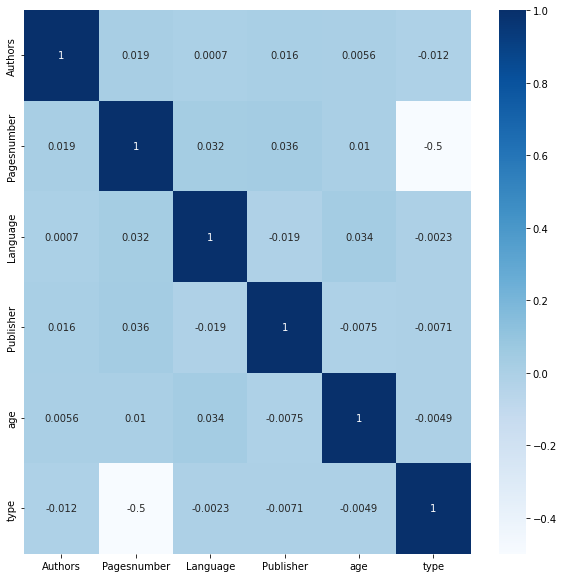

In [102]:
plt.figure(figsize=(10,10))
sns.heatmap(df_2.corr(),annot=True,cmap='Blues')

In [111]:
x=df_2[['Description','Pagesnumber','type','Language','Authors','Publisher']]
y=df_2['age'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,shuffle=True,stratify=y)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))

368826 122942 368826 122942
276619 92207 276619 92207
207464 69155 207464 69155
155598 51866 155598 51866
116698 38900 116698 38900
87523 29175 87523 29175
65642 21881 65642 21881
49231 16411 49231 16411
36923 12308 36923 12308
27692 9231 27692 9231
20769 6923 20769 6923
15576 5193 15576 5193
11682 3894 11682 3894
8761 2921 8761 2921
6570 2191 6570 2191
4927 1643 4927 1643


In [113]:
x_train

,Description,Pagesnumber,type,Language,Authors,Publisher
337158,When the Jezebel River overflows her banks and...,300,2,1,132290,20036
170889,Something horrible lurks in Cabal City. <br />...,300,2,1,135113,24129
311105,"Sarah and Nicholas Fraser, the irrepressible s...",200,2,1,43718,6466
356372,<b>WEDDING MANNERS FOR MODERN TIMES FROM THE E...,300,2,1,41271,8617
447663,Little Shark is born one day in the dark deepn...,0,2,1,8367,23494
...,...,...,...,...,...,...
227693,The Rough Guide to Cult Pop is devoted to pop ...,400,2,1,131306,18973
417107,"Seuls rescapés de la famille Pawulski, Élisabe...",600,2,1,9707,12408
390955,Nipping at the heels of the best-selling <i>Le...,200,2,1,57666,4623
114916,In this comprehensive must-have guide to queer...,200,2,13,4581,496


In [123]:
for i in x_train['Description'].index:
    tmp=""
    if type(x_train['Description'][i]=='str'): 
        tmp=x_train['Description'][i]
    else:
        for j in range(len(x_train['Description'][i])):
            tmp+=x_train['Description'][i].values[j]+" "
    x_train['Description'].loc[i]=tmp[:500]

In [127]:
for i in x_test['Description'].index:
    tmp=""
    if type(x_test['Description'][i]=='str'): 
        tmp=x_test['Description'][i]
    else:
        for j in range(len(x_test['Description'][i])):
            tmp+=x_test['Description'][i].values[j]+" "
    x_test['Description'].loc[i]=tmp[:500]

In [126]:
x_train['Description'][i]

"When Céleste Mogador's memoirs were first published in 1854 and again in 1858, they were immediately seized and condemned as immoral and unsuitable for public consumption. For a reader in our more forgiving times, this extraordinary document offers not only a portrait of the early life of an intelligent, courageous, and infinitely intriguing Frenchwoman but also an exceedingly rare inside look at the world of the courtesans and prostitutes of nineteenth-century France.\xa0Writing to conciliate judg"

In [128]:
x_test['Description'][i]

'Anyone with a rudimentary knowledge of either Reiki or shamanism will learn how to heal people, places, and things, whether at hand or from a distance, in this useful guide. Presented by an expert in both traditions, the techniques of Reiki and the principles of shamanism are explained in simple, concise terms, then brought together using real-life examples to show how Reiki can be practiced within the shamanic journey. Supported by mastery exercises, references to other books, and internet reso'

<a id="section-model"></a>
<h1 style='background:#f3f873;color:magenta'>Machine learning</h1>

In [135]:
x_train.shape

(4927, 6)

In [136]:
X.shape

(6570,)

In [137]:
x_test.shape

(1643, 6)

In [134]:
X=np.concatenate((x_train['Description'].values,x_test['Description'].values),axis=0)
y_train

array([1, 3, 3, ..., 3, 3, 3])

In [139]:
cvec=CountVectorizer(analyzer='word', ngram_range=(2, 2),max_features=500)
cv_trans=cvec.fit_transform(X)
cv_trans.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [211]:
pd.DataFrame(data=cv_trans.toarray(),columns=cvec.get_feature_names())

,able to,about the,about to,account of,across the,after the,against the,age of,all of,all the,...,year old,years ago,years of,york times,you are,you can,you ll,you re,you will,young woman
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
x_tr_cv=cv_trans.toarray()[:4927,:]
x_te_cv=cv_trans.toarray()[4927:,:]

In [152]:
scaler = StandardScaler()
std_x_tr=scaler.fit_transform(x_train[['Pagesnumber','type','Language','Authors','Publisher']].to_numpy())
std_x_tr

array([[ 0.11727583,  0.08669088, -0.4494724 ,  1.18089429,  0.94249771],
       [ 0.11727583,  0.08669088, -0.4494724 ,  1.24274474,  1.50857294],
       [-0.34609067,  0.08669088, -0.4494724 , -0.75967155, -0.93427749],
       ...,
       [-0.34609067,  0.08669088, -0.4494724 , -0.45407822, -1.1891704 ],
       [-0.34609067,  0.08669088,  0.94559329, -1.6171426 , -1.75994794],
       [ 0.11727583,  0.08669088, -0.4494724 , -1.25524192,  1.3244913 ]])

In [153]:
std_x_te=scaler.fit_transform(x_test[['Pagesnumber','type','Language','Authors','Publisher']].to_numpy())
std_x_te

array([[-0.86284934,  0.07729071, -0.45597773,  0.72651586,  0.36409725],
       [ 1.22118074,  0.07729071,  0.86959834, -0.66496136, -0.44209275],
       [ 0.1791657 ,  0.07729071, -0.45597773,  1.24381767, -0.3308221 ],
       ...,
       [ 0.1791657 ,  0.07729071, -0.45597773, -1.30424476, -1.45160585],
       [ 0.70017322,  0.07729071, -0.45597773, -1.67984019, -1.76731369],
       [-0.34184182,  0.07729071, -0.45597773, -0.16618079, -0.73036591]])

In [154]:
x_tr_prep=np.concatenate((std_x_tr,x_tr_cv),axis=1)
x_te_prep=np.concatenate((std_x_te,x_te_cv),axis=1)

In [156]:
x_tr_prep.shape

(4927, 505)

In [165]:
from sklearn.model_selection import GridSearchCV
clf_svc = GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,5,10,15,20,30,50],
    'kernel': ['rbf','linear','sigmoid','poly'],
    'max_iter':[1,5,10,20,100]
}, cv= 5)
clf_svc.fit(x_tr_prep[:,-500:],y_train)

GridSearchCV(cv=5, estimator=SVC(gamma='auto'),
             param_grid={'C': [1, 5, 10, 15, 20, 30, 50],
                         'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
                         'max_iter': [1, 5, 10, 20, 100]})

In [166]:
print(clf_svc.best_params_)
print(clf_svc.best_score_)

{'C': 1, 'kernel': 'poly', 'max_iter': 100}
0.6036130188115856


In [172]:
clf_svc_2 = GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,5,10,15,20,30,50],
    'kernel': ['rbf','linear','sigmoid','poly'],
    'max_iter':[1,5,10,20,100]
}, cv= 5)
clf_svc_2.fit(x_tr_prep[:,:],y_train)
print(clf_svc_2.best_params_)
print(clf_svc_2.best_score_)

{'C': 1, 'kernel': 'poly', 'max_iter': 20}
0.6023953624859711


In [164]:
clf_lr=GridSearchCV(LogisticRegression(random_state=0,max_iter=200),{'solver':['newton-cg','sag','saga','lbfgs']},cv=5)
clf_lr.fit(x_tr_prep[:,-500:],y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)
#clf_rf=RandomForestClassifier(n_estimators=300, max_depth=5, random_state=1)

{'solver': 'newton-cg'}
0.5534825629884371


In [171]:
clf_lr_2=GridSearchCV(LogisticRegression(random_state=0,max_iter=200),{'solver':['newton-cg','sag','saga','lbfgs']},cv=5)
clf_lr_2.fit(x_tr_prep[:,:],y_train)
print(clf_lr_2.best_params_)
print(clf_lr_2.best_score_)

{'solver': 'saga'}
0.5528744555760341


In [169]:
clf_rf=GridSearchCV(RandomForestClassifier(n_estimators=300),{'max_depth':[3,4,5],
                                                              'max_features':['sqrt','log2'],
                                                              'criterion':['gini','entropy','logloss']},cv=5)
clf_rf.fit(x_tr_prep[:,-500:],y_train)
print(clf_rf.best_params_)
print(clf_rf.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt'}
0.6044247896953285


In [170]:
clf_rf_2=GridSearchCV(RandomForestClassifier(n_estimators=300),{'max_depth':[3,4,5],
                                                              'max_features':['sqrt','log2'],
                                                              'criterion':['gini','entropy','logloss']},cv=5)
clf_rf_2.fit(x_tr_prep[:,:],y_train)
print(clf_rf_2.best_params_)
print(clf_rf_2.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt'}
0.6044247896953285


## COUNT VECTORIZER SCORES

In [180]:
def pl_confuse(actual_class,pred_class):
    plt.figure(figsize = (18,8))
    sns.heatmap(confusion_matrix(actual_class, pred_class), annot = True, xticklabels = np.unique(actual_class), yticklabels = np.unique(actual_class), cmap = 'summer')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
def print_metrics(actual_class,pred_class,average="macro"):
    unique_class = set(actual_class)
    roc_auc_dict = dict()
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc
    print(f'ROC_AUC_DICT = {roc_auc_dict}\n','*'*40)
    print("f1_score macro = ", f1_score(actual_class,pred_class,average="macro"),"\n","*"*50)
    print("f1_score micro (or accuracy) = ", f1_score(actual_class,pred_class,average="micro"),"\n","*"*50)
    cm = confusion_matrix(actual_class, pred_class)
    #pl_confuse(actual_class,cm)
    recall = recall_score(actual_class,pred_class,average='weighted') # np.diag(cm) / np.sum(cm, axis = 1)
    precision = precision_score(actual_class,pred_class,average='weighted')  #np.diag(cm) / np.sum(cm, axis = 0)
    print("PRECISION = ",precision," AVERAGED PRECSION = ",np.mean(precision),"\n","*"*50)
    print("RECALL = ",recall," AVERAGED RECALL = ",np.mean(recall),"\n","*"*50)
    print(classification_report(actual_class,pred_class),"\n","*"*50)
    pl_confuse(actual_class,pred_class)

ROC_AUC_DICT = {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5}
 ****************************************
f1_score macro =  0.18835356600910472 
 **************************************************
f1_score micro (or accuracy) =  0.6043822276323798 
 **************************************************
PRECISION =  0.36527787707787773  AVERAGED PRECSION =  0.36527787707787773 
 **************************************************
RECALL =  0.6043822276323798  AVERAGED RECALL =  0.6043822276323798 
 **************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.00      0.00      0.00       461
           2       0.00      0.00      0.00        47
           3       0.60      1.00      0.75       993

    accuracy                           0.60      1643
   macro avg       0.15      0.25      0.19      1643
weighted avg       0.37      0.60      0.46      1643
 
 *****************************

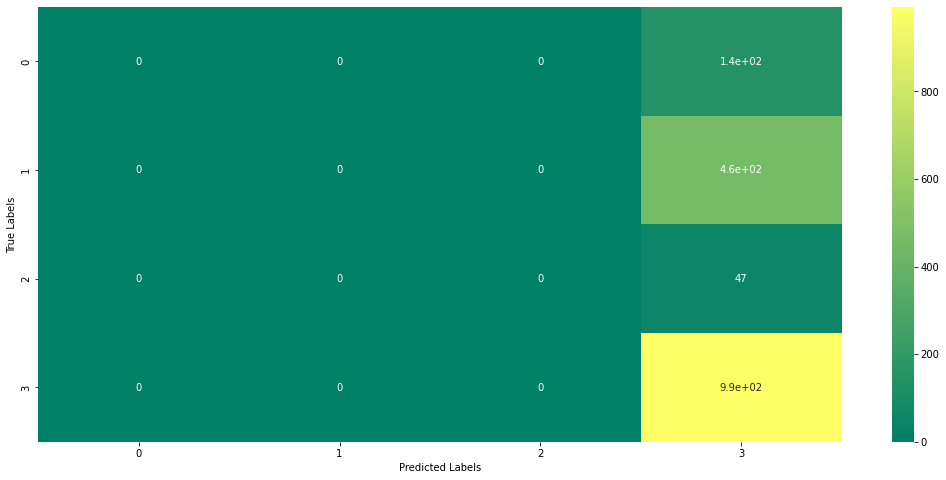

In [188]:
y_rf_hat=clf_rf.predict(x_te_prep[:,-500:])
print_metrics(y_test,y_rf_hat)

ROC_AUC_DICT = {0: 0.5057567255632396, 1: 0.5125242704192681, 2: 0.4974937343358396, 3: 0.5070725850182043}
 ****************************************
f1_score macro =  0.24087646253298778 
 **************************************************
f1_score micro (or accuracy) =  0.5569080949482653 
 **************************************************
PRECISION =  0.4686302377607142  AVERAGED PRECSION =  0.4686302377607142 
 **************************************************
RECALL =  0.5569080949482653  AVERAGED RECALL =  0.5569080949482653 
 **************************************************
              precision    recall  f1-score   support

           0       0.14      0.03      0.05       142
           1       0.32      0.16      0.21       461
           2       0.00      0.00      0.00        47
           3       0.61      0.84      0.71       993

    accuracy                           0.56      1643
   macro avg       0.27      0.26      0.24      1643
weighted avg       0.47     

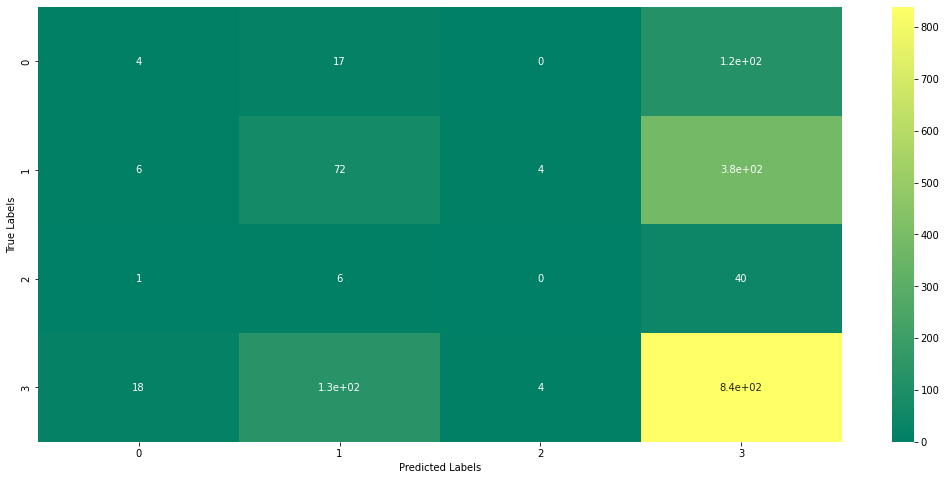

In [185]:
y_lr_hat=clf_lr.predict(x_te_prep[:,-500:])
print_metrics(y_test,y_lr_hat)

ROC_AUC_DICT = {0: 0.5025217929830817, 1: 0.5006615868541499, 2: 0.5, 3: 0.4995243628476257}
 ****************************************
f1_score macro =  0.19252738482937093 
 **************************************************
f1_score micro (or accuracy) =  0.603164942178941 
 **************************************************
PRECISION =  0.527038869478668  AVERAGED PRECSION =  0.527038869478668 
 **************************************************
RECALL =  0.603164942178941  AVERAGED RECALL =  0.603164942178941 
 **************************************************
              precision    recall  f1-score   support

           0       0.25      0.01      0.01       142
           1       0.50      0.00      0.00       461
           2       0.00      0.00      0.00        47
           3       0.60      1.00      0.75       993

    accuracy                           0.60      1643
   macro avg       0.34      0.25      0.19      1643
weighted avg       0.53      0.60      0.46     

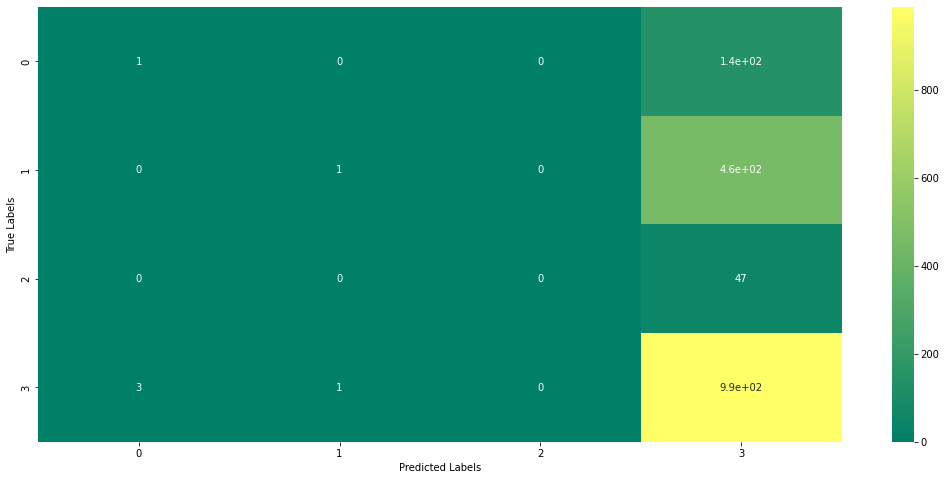

In [186]:
y_svc_hat=clf_svc.predict(x_te_prep[:,-500:])
print_metrics(y_test,y_svc_hat)


In [189]:
print("SVC count_vectorizer report:\n",classification_report(y_test,y_svc_hat),"\n","*"*50)
print("RF count_vectorizer report:\n",classification_report(y_test,y_rf_hat),"\n","*"*50)
print("LR count_vectorizer report:\n",classification_report(y_test,y_lr_hat),"\n","*"*50)

SVC count_vectorizer report:
               precision    recall  f1-score   support

           0       0.25      0.01      0.01       142
           1       0.50      0.00      0.00       461
           2       0.00      0.00      0.00        47
           3       0.60      1.00      0.75       993

    accuracy                           0.60      1643
   macro avg       0.34      0.25      0.19      1643
weighted avg       0.53      0.60      0.46      1643
 
 **************************************************
RF count_vectorizer report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.00      0.00      0.00       461
           2       0.00      0.00      0.00        47
           3       0.60      1.00      0.75       993

    accuracy                           0.60      1643
   macro avg       0.15      0.25      0.19      1643
weighted avg       0.37      0.60      0.46      1643
 
 ****************

In [192]:
#std_x_tr
#std_x_te
tf_idf = TfidfVectorizer(ngram_range=(1, 3), max_features = 1000, binary=True, smooth_idf=False)
x_tfidf = tf_idf.fit_transform(X)

<6570x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 218753 stored elements in Compressed Sparse Row format>

In [193]:
x_tr_tf=x_tfidf.toarray()[:4927,:]
x_te_tf=x_tfidf.toarray()[4927:,:]

In [195]:
x_tr2_tf=np.concatenate((std_x_tr,x_tr_tf),axis=1)
x_te2_tf=np.concatenate((std_x_te,x_te_tf),axis=1)

In [196]:
x_tr2_tf.shape

(4927, 1005)

In [197]:
from sklearn.model_selection import GridSearchCV
clf_svc = GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,5,10,15,20,30,50],
    'kernel': ['rbf','linear','sigmoid','poly'],
    'max_iter':[1,5,10,20,100]
}, cv= 5)
clf_svc.fit(x_tr2_tf[:,-1000:],y_train)

GridSearchCV(cv=5, estimator=SVC(gamma='auto'),
             param_grid={'C': [1, 5, 10, 15, 20, 30, 50],
                         'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
                         'max_iter': [1, 5, 10, 20, 100]})

In [198]:
print(clf_svc.best_params_,clf_svc.best_score_)

{'C': 1, 'kernel': 'poly', 'max_iter': 100} 0.5989433799075381


In [199]:
#from sklearn.model_selection import GridSearchCV
clf_svc_2 = GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,5,10,15,20,30,50],
    'kernel': ['rbf','linear','sigmoid','poly'],
    'max_iter':[1,5,10,20,100]
}, cv= 5)
clf_svc_2.fit(x_tr2_tf[:,:],y_train)
print(clf_svc.best_params_,clf_svc.best_score_)

{'C': 1, 'kernel': 'poly', 'max_iter': 100} 0.5989433799075381


In [205]:
print(clf_svc_2.best_params_,clf_svc_2.best_score_)

{'C': 1, 'kernel': 'poly', 'max_iter': 100} 0.6028012479278426


In [200]:
clf_rf=GridSearchCV(RandomForestClassifier(n_estimators=300),{'max_depth':[3,4,5],
                                                              'max_features':['sqrt','log2'],
                                                              'criterion':['gini','entropy','logloss']},cv=5)
clf_rf.fit(x_tr2_tf[:,-1000:],y_train)
print(clf_rf.best_params_)
print(clf_rf.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt'}
0.6044247896953285


In [201]:
clf_rf_2=GridSearchCV(RandomForestClassifier(n_estimators=300),{'max_depth':[3,4,5],
                                                              'max_features':['sqrt','log2'],
                                                              'criterion':['gini','entropy','logloss']},cv=5)
clf_rf_2.fit(x_tr2_tf[:,:],y_train)
print(clf_rf_2.best_params_)
print(clf_rf_2.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt'}
0.6044247896953285


In [203]:
clf_lr=GridSearchCV(LogisticRegression(random_state=0,max_iter=200),{'solver':['newton-cg','sag','saga','lbfgs']},cv=5)
clf_lr.fit(x_tr2_tf[:,-1000:],y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

{'solver': 'newton-cg'}
0.5818982506358049


In [202]:
clf_lr_2=GridSearchCV(LogisticRegression(random_state=0,max_iter=200),{'solver':['newton-cg','sag','saga','lbfgs']},cv=5)
clf_lr_2.fit(x_tr2_tf[:,:],y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

{'solver': 'newton-cg'}
0.5534825629884371


In [207]:
y_hat_clf_lr=clf_lr.predict(x_te2_tf[:,-1000:])
print("LR ONLY TEXT FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_lr),"\n","*"*50)
y_hat_clf_lr_2=clf_lr_2.predict(x_te2_tf[:,:])
print("LR ALL FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_lr_2),"\n","*"*50)
y_hat_clf_svc=clf_svc.predict(x_te2_tf[:,-1000:])
print("SVC ONLY TEXT FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_svc),"\n","*"*50)
y_hat_clf_svc_2=clf_svc_2.predict(x_te2_tf[:,:])
print("SVC ALL FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_svc_2),"\n","*"*50)
y_hat_clf_rf=clf_rf.predict(x_te2_tf[:,-1000:])
print("RF ONLY TEXT FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_rf),"\n","*"*50)
y_hat_clf_rf_2=clf_rf_2.predict(x_te2_tf[:,:])
print("RF ALL FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_rf_2),"\n","*"*50)

LR ONLY TEXT FEATURES - TFIDF REPORT:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.41      0.20      0.26       461
           2       0.00      0.00      0.00        47
           3       0.63      0.90      0.74       993

    accuracy                           0.60      1643
   macro avg       0.26      0.27      0.25      1643
weighted avg       0.49      0.60      0.52      1643
 
 **************************************************
LR ALL FEATURES - TFIDF REPORT:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.43      0.19      0.26       461
           2       0.00      0.00      0.00        47
           3       0.63      0.92      0.75       993

    accuracy                           0.61      1643
   macro avg       0.26      0.28      0.25      1643
weighted avg       0.50      0.61      0.52      1643
 
 ***

ROC_AUC_DICT = {0: 0.5, 1: 0.5417763194115639, 2: 0.5, 3: 0.5473119529010768}
 ****************************************
f1_score macro =  0.251469890742266 
 **************************************************
f1_score micro (or accuracy) =  0.6001217285453438 
 **************************************************
PRECISION =  0.4948386918500462  AVERAGED PRECSION =  0.4948386918500462 
 **************************************************
RECALL =  0.6001217285453438  AVERAGED RECALL =  0.6001217285453438 
 **************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.41      0.20      0.26       461
           2       0.00      0.00      0.00        47
           3       0.63      0.90      0.74       993

    accuracy                           0.60      1643
   macro avg       0.26      0.27      0.25      1643
weighted avg       0.49      0.60      0.52      1643
 
 ***

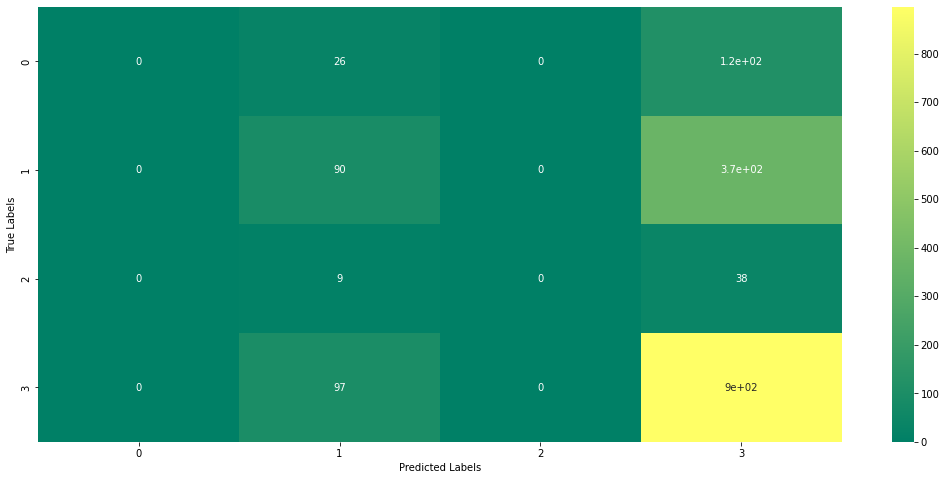

In [208]:
print_metrics(y_test,y_hat_clf_lr)

ROC_AUC_DICT = {0: 0.5, 1: 0.5446291259712756, 2: 0.5, 3: 0.5489766829343868}
 ****************************************
f1_score macro =  0.2518129990012221 
 **************************************************
f1_score micro (or accuracy) =  0.6062081558125381 
 **************************************************
PRECISION =  0.5014572529101768  AVERAGED PRECSION =  0.5014572529101768 
 **************************************************
RECALL =  0.6062081558125381  AVERAGED RECALL =  0.6062081558125381 
 **************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.43      0.19      0.26       461
           2       0.00      0.00      0.00        47
           3       0.63      0.92      0.75       993

    accuracy                           0.61      1643
   macro avg       0.26      0.28      0.25      1643
weighted avg       0.50      0.61      0.52      1643
 
 **

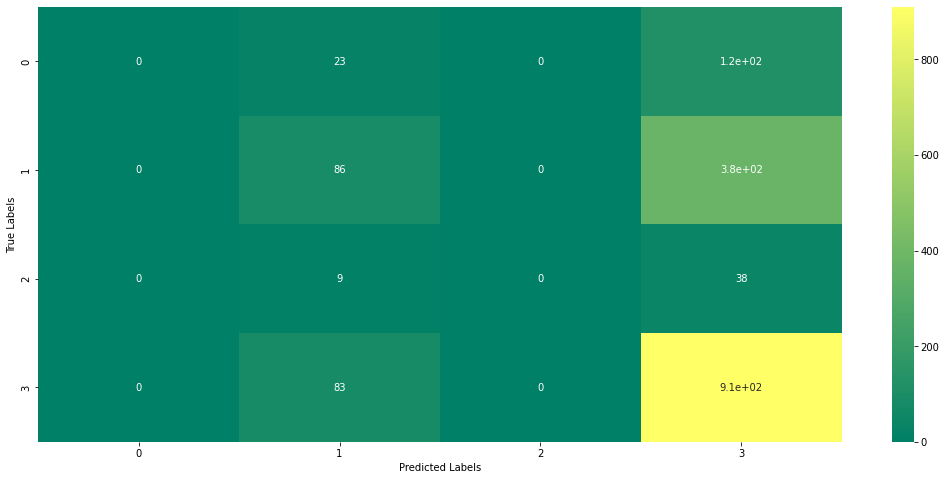

In [214]:
print_metrics(y_test,y_hat_clf_lr_2)

ROC_AUC_DICT = {0: 0.5028549042422423, 1: 0.49733163027480176, 2: 0.49592731829573933, 3: 0.4961112402200015}
 ****************************************
f1_score macro =  0.19290982409174282 
 **************************************************
f1_score micro (or accuracy) =  0.5928180158247109 
 **************************************************
PRECISION =  0.44245487234031994  AVERAGED PRECSION =  0.44245487234031994 
 **************************************************
RECALL =  0.5928180158247109  AVERAGED RECALL =  0.5928180158247109 
 **************************************************
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       142
           1       0.18      0.01      0.01       461
           2       0.00      0.00      0.00        47
           3       0.60      0.98      0.75       993

    accuracy                           0.59      1643
   macro avg       0.28      0.25      0.19      1643
weighted avg       0.44 

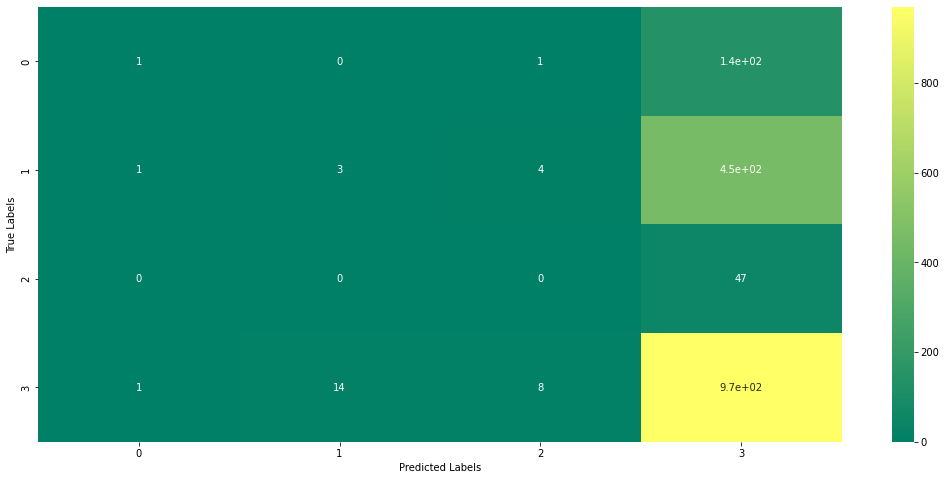

In [215]:
print_metrics(y_test,y_hat_clf_svc)

ROC_AUC_DICT = {0: 0.4996668887408394, 1: 0.5, 2: 0.5, 3: 0.5007692307692307}
 ****************************************
f1_score macro =  0.1884250474383302 
 **************************************************
f1_score micro (or accuracy) =  0.6043822276323798 
 **************************************************
PRECISION =  0.36550033619911887  AVERAGED PRECSION =  0.36550033619911887 
 **************************************************
RECALL =  0.6043822276323798  AVERAGED RECALL =  0.6043822276323798 
 **************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.00      0.00      0.00       461
           2       0.00      0.00      0.00        47
           3       0.60      1.00      0.75       993

    accuracy                           0.60      1643
   macro avg       0.15      0.25      0.19      1643
weighted avg       0.37      0.60      0.46      1643
 
 

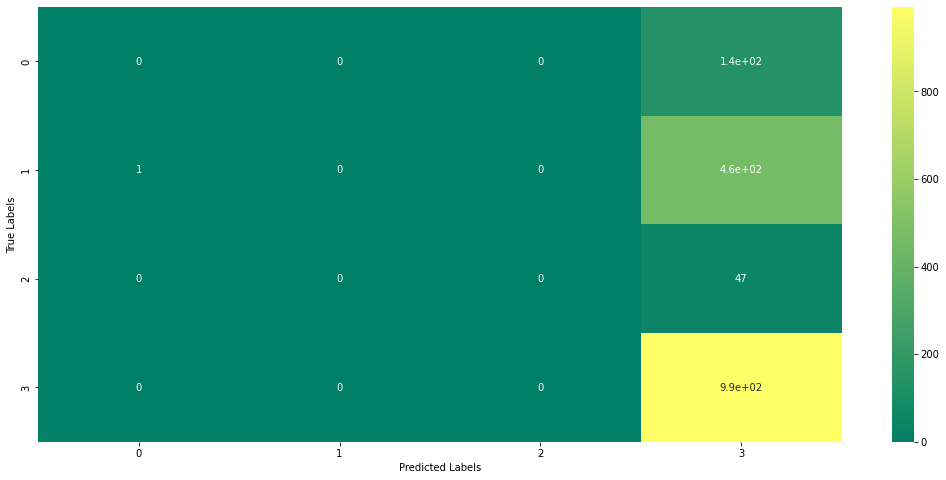

In [216]:
print_metrics(y_test,y_hat_clf_svc_2)

ROC_AUC_DICT = {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5}
 ****************************************
f1_score macro =  0.18835356600910472 
 **************************************************
f1_score micro (or accuracy) =  0.6043822276323798 
 **************************************************
PRECISION =  0.36527787707787773  AVERAGED PRECSION =  0.36527787707787773 
 **************************************************
RECALL =  0.6043822276323798  AVERAGED RECALL =  0.6043822276323798 
 **************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.00      0.00      0.00       461
           2       0.00      0.00      0.00        47
           3       0.60      1.00      0.75       993

    accuracy                           0.60      1643
   macro avg       0.15      0.25      0.19      1643
weighted avg       0.37      0.60      0.46      1643
 
 *****************************

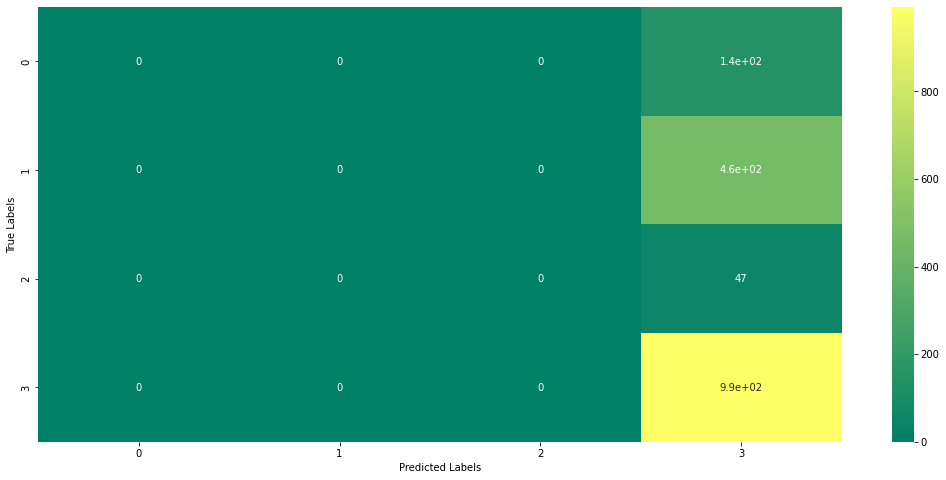

In [217]:
print_metrics(y_test,y_hat_clf_rf)

ROC_AUC_DICT = {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5}
 ****************************************
f1_score macro =  0.18835356600910472 
 **************************************************
f1_score micro (or accuracy) =  0.6043822276323798 
 **************************************************
PRECISION =  0.36527787707787773  AVERAGED PRECSION =  0.36527787707787773 
 **************************************************
RECALL =  0.6043822276323798  AVERAGED RECALL =  0.6043822276323798 
 **************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.00      0.00      0.00       461
           2       0.00      0.00      0.00        47
           3       0.60      1.00      0.75       993

    accuracy                           0.60      1643
   macro avg       0.15      0.25      0.19      1643
weighted avg       0.37      0.60      0.46      1643
 
 *****************************

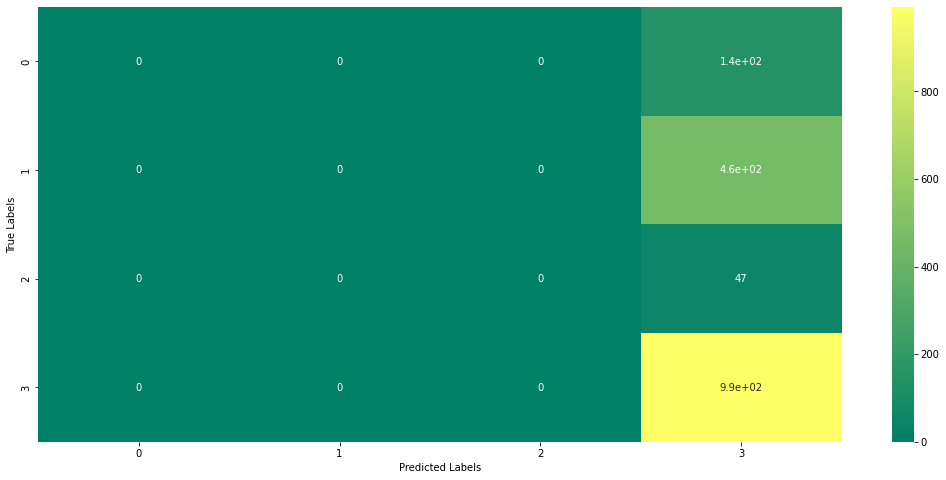

In [218]:
print_metrics(y_test,y_hat_clf_rf_2)

In [213]:
# Baseline scores (assuming the same prediction for all data samples)
from sklearn.metrics import mean_squared_error
rmse_test = mean_squared_error(y_test, y_hat_clf_lr, squared=False)
#rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for test {round(rmse_bs_test,3)} points")

RMSE baseline score for test 1.099 points
